In [1]:
from google.colab import drive

import time
import zipfile
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
drive.mount('/content/drive')
!ls /content/drive



Mounted at /content/drive
MyDrive  Othercomputers


In [3]:
zip_file='/content/drive/MyDrive/archive.zip'

z=zipfile.ZipFile(zip_file,'r')
z.extractall()

print(os.listdir())

['.config', 'drive', 'annotations', 'images', 'sample_data']


In [4]:
!ls

annotations  drive  images  sample_data


In [5]:
images_path = Path('images')
anno_path = Path('annotations')


def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [6]:
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,images/road24.png,267,400,trafficlight,70,174,128,286
1,images/road846.png,300,400,trafficlight,208,224,228,278
2,images/road131.png,400,267,crosswalk,156,8,177,31
3,images/road237.png,300,400,speedlimit,125,158,140,174
4,images/road132.png,400,300,crosswalk,184,23,243,82
...,...,...,...,...,...,...,...,...
872,images/road473.png,300,400,speedlimit,92,112,237,257
873,images/road808.png,300,400,speedlimit,115,199,135,219
874,images/road316.png,300,400,speedlimit,115,138,181,202
875,images/road653.png,300,400,speedlimit,161,219,181,240


In [7]:
df_train['class'].value_counts()

speedlimit      652
crosswalk        88
stop             76
trafficlight     61
Name: class, dtype: int64

In [8]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,images/road24.png,267,400,3,70,174,128,286
1,images/road846.png,300,400,3,208,224,228,278
2,images/road131.png,400,267,2,156,8,177,31
3,images/road237.png,300,400,0,125,158,140,174
4,images/road132.png,400,300,2,184,23,243,82


In [9]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)


def create_mask(bb, x):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def create_bb_array(x):
    """Генерируем массив bounding box'a из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])


def resize_image_bb(read_path, write_path, bb, sz):
    """Ресайзим изображение и его bounding box и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [10]:
IM_SIZE = 300

In [11]:
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')
Path.mkdir(train_path_resized, exist_ok=True)


for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

df_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,images/road24.png,267,400,3,70,174,128,286,images_resized/road24.png,"[130.0, 78.0, 214.0, 143.0]"
1,images/road846.png,300,400,3,208,224,228,278,images_resized/road846.png,"[168.0, 208.0, 208.0, 227.0]"
2,images/road131.png,400,267,2,156,8,177,31,images_resized/road131.png,"[8.0, 117.0, 34.0, 132.0]"
3,images/road237.png,300,400,0,125,158,140,174,images_resized/road237.png,"[118.0, 125.0, 130.0, 139.0]"
4,images/road132.png,400,300,2,184,23,243,82,images_resized/road132.png,"[23.0, 138.0, 81.0, 182.0]"


(400, 300, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


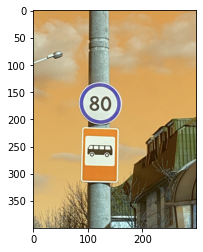

In [12]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

Y = create_mask(bb, im)
mask_to_bb(Y)

plt.imshow(im)


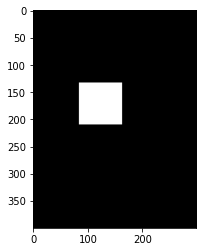

In [13]:
plt.imshow(Y, cmap='gray')

In [14]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix * c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    YY = crop(Y, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, is_transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

images_resized/road625.png


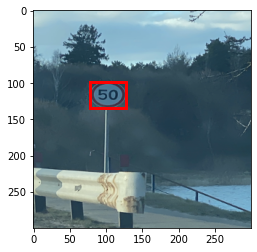

In [15]:
number = 25
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


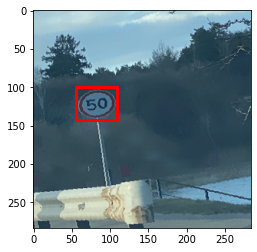

In [16]:
im, bb = transformsXY(str(df_train['new_path'].values[number]),
                      df_train['new_bb'].values[number],
                      is_transforms=True)
show_corner_bb(im, bb)

In [17]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]


class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, is_transforms=False):
        self.is_transforms = is_transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.is_transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

    
train_ds = RoadDataset(X_train['new_path'], X_train['new_bb'], y_train, is_transforms=True)
valid_ds = RoadDataset(X_val['new_path'], X_val['new_bb'], y_val)

In [18]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [19]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [20]:
resnet = models.resnet34(pretrained=True)
list(resnet.children())[:8]

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [21]:
model = BB_model().cuda()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)
epochs = 1000
model

BB_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [22]:
def train():
    for i in range(epochs):

        model.train()
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            
            # losses
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total += len_batch
            sum_loss += loss.item()
        
        train_loss = sum_loss / total

        # Eval
        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0

        for x, y_class, y_bb in valid_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
            
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total

        print(f"Epoch [{i+1}/{epochs}]. train_loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}")

In [23]:
train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Epoch [1/25]. train_loss 500.767 val_loss 337.195 val_acc 0.773
Epoch [2/25]. train_loss 220.954 val_loss 132.312 val_acc 0.773
Epoch [3/25]. train_loss 154.221 val_loss 147.384 val_acc 0.739
Epoch [4/25]. train_loss 152.429 val_loss 134.945 val_acc 0.665
Epoch [5/25]. train_loss 151.965 val_loss 153.410 val_acc 0.773
Epoch [6/25]. train_loss 150.528 val_loss 134.384 val_acc 0.773
Epoch [7/25]. train_loss 150.925 val_loss 139.231 val_acc 0.778
Epoch [8/25]. train_loss 146.805 val_loss 548.467 val_acc 0.773
Epoch [9/25]. train_loss 146.455 val_loss 127.863 val_acc 0.773
Epoch [10/25]. train_loss 144.965 val_loss 336.128 val_acc 0.790
Epoch [11/25]. train_loss 140.353 val_loss 130.894 val_acc 0.790
Epoch [12/25]. train_loss 135.522 val_loss 128.019 val_acc 0.778
Epoch [13/25]. train_loss 133.667 val_loss 137.971 val_acc 0.784
Epoch [14/25]. train_loss 131.716 val_loss 121.681 val_acc 0.790
Epoch [15/25]. train_loss 131.574 val_loss 128.781 val_acc 0.761
Epoch [16/25]. train_loss 130.992 

In [24]:
# resizing test image
im = read_image('./images_resized/road789.png')
Path.mkdir(Path('./road_signs_test'), exist_ok=True)
cv2.imwrite('./road_signs_test/road789.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [25]:
# test Dataset
test_ds = RoadDataset(
    pd.DataFrame([{'path':'./road_signs_test/road789.jpg'}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y']
)
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


torch.Size([1, 3, 284, 284])

In [26]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 2.4545, -1.3349, -0.4686, -1.3039]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[144.6236, 105.6413, 196.6108, 166.9209]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [27]:
torch.max(out_class, 1)

torch.return_types.max(values=tensor([2.4545], device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([0], device='cuda:0'))

In [28]:
class_dict

{'crosswalk': 2, 'speedlimit': 0, 'stop': 1, 'trafficlight': 3}

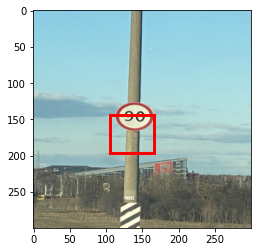

In [29]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

In [30]:
!ls

annotations  drive  images  images_resized  road_signs_test  sample_data


In [36]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('Файл(ы) "{name}" размером {length} байт загружен(ы)'.format(
      name=fn, length=len(uploaded[fn])))

Saving ejoxja1qf44.jpg to ejoxja1qf44.jpg
Файл(ы) "ejoxja1qf44.jpg" размером 563702 байт загружен(ы)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


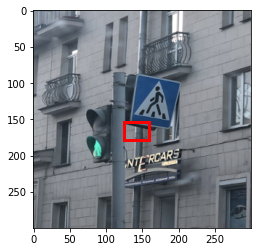

In [41]:
# resizing test image
im = read_image('./images_resized/road300.png')
Path.mkdir(Path('./road_signs_test'), exist_ok=True)
cv2.imwrite('./road_signs_test/road300.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
# test Dataset
test_ds = RoadDataset(
    pd.DataFrame([{'path':'./road_signs_test/road300.jpg'}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y']
)
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb
torch.max(out_class, 1)
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])